In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import shap
import lime
import lime.lime_image
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from datetime import datetime
from keras.applications.vgg16 import preprocess_input

warnings.simplefilter(action='ignore', category=FutureWarning)

# Define paths
train_dir = 'trainset70'
test_dir = 'testset30'


In [4]:
# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                              batch_size=16, class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                            batch_size=16, class_mode='categorical')


Found 7010 images belonging to 7 classes.
Found 3005 images belonging to 7 classes.


In [7]:
# Model definition
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    Conv2D(filters=16, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    # Removed further Conv2D and MaxPool2D layers to prevent excessive downsampling
    
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.25),
    Dense(units=128, activation='relu'),
    Dropout(0.25),
    Dense(units=64, activation='relu'),
    Dropout(0.20),
    Dense(units=7, activation='softmax')
])

model.summary()

optimizer = Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
checkpoint = ModelCheckpoint(filepath='proposedcnn.h5', verbose=1, save_best_only=True)

start = datetime.now()

Model_history = model.fit(train_set, validation_data=test_set, epochs=40,
                          callbacks=[checkpoint], verbose=1)
duration = datetime.now() - start
print("Training completed in time:", duration)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_53 (Conv2D)          (None, 222, 222, 16)      2320      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 111, 111, 32)      4640      
                                                                 
 conv2d_55 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                 

Final Training Accuracy: 0.7790
Final Validation Accuracy: 0.7677


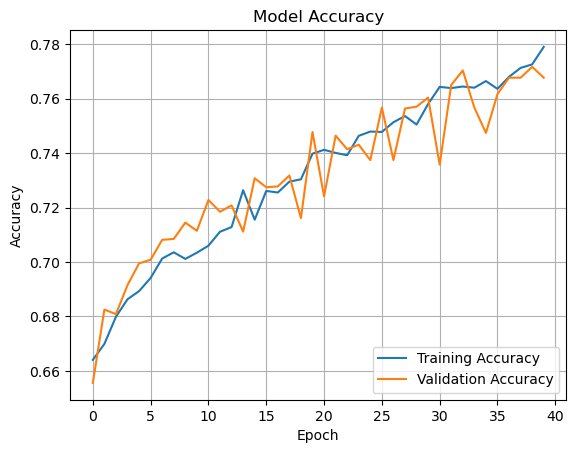

In [8]:
# Get accuracy from the training history
training_accuracy = Model_history.history['accuracy']
validation_accuracy = Model_history.history['val_accuracy']

# Print the final training and validation accuracy
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

# Plot the training and validation accuracy
plt.plot(Model_history.history['accuracy'], label='Training Accuracy')
plt.plot(Model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()


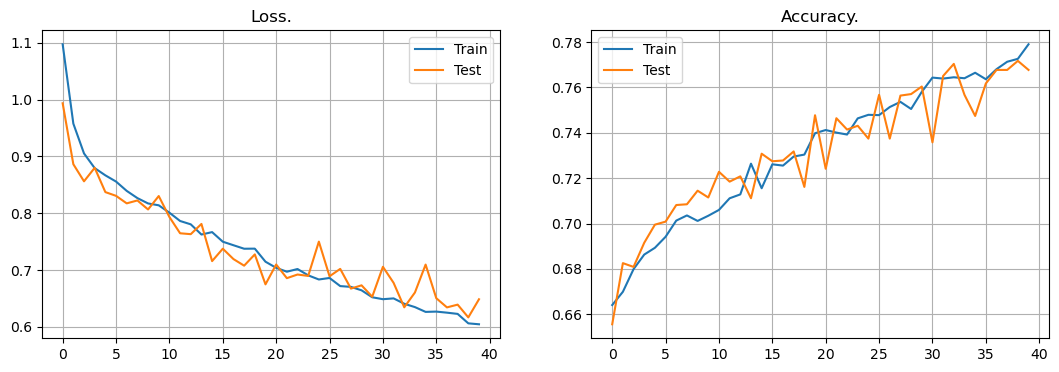

In [9]:
# Metrics visualization
metrics = Model_history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.title("Loss.")
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.grid(True)
plt.legend(loc="best")
plt.savefig("cnn_73_loss.png", bbox_inches="tight")
plt.subplot(1, 2, 2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label="Train")
plt.plot(test_accuracy, label="Test")
plt.grid(True)
plt.legend(loc="best")
plt.savefig("cnn_73_accuracy.png", bbox_inches="tight")


188/188 [==============================] - 16s 85ms/step
              precision    recall  f1-score      support
akiec          0.036145  0.027523  0.031250   109.000000
bcc            0.019608  0.012821  0.015504   156.000000
bkl            0.119186  0.122024  0.120588   336.000000
df             0.000000  0.000000  0.000000    42.000000
mel            0.108696  0.102041  0.105263   343.000000
nv             0.659765  0.710233  0.684069  1974.000000
vasc           0.000000  0.000000  0.000000    45.000000
accuracy       0.493511  0.493511  0.493511     0.493511
macro avg      0.134771  0.139234  0.136668  3005.000000
weighted avg   0.461465  0.493511  0.476806  3005.000000


c:\Users\Jeewan\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeewan\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jeewan\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


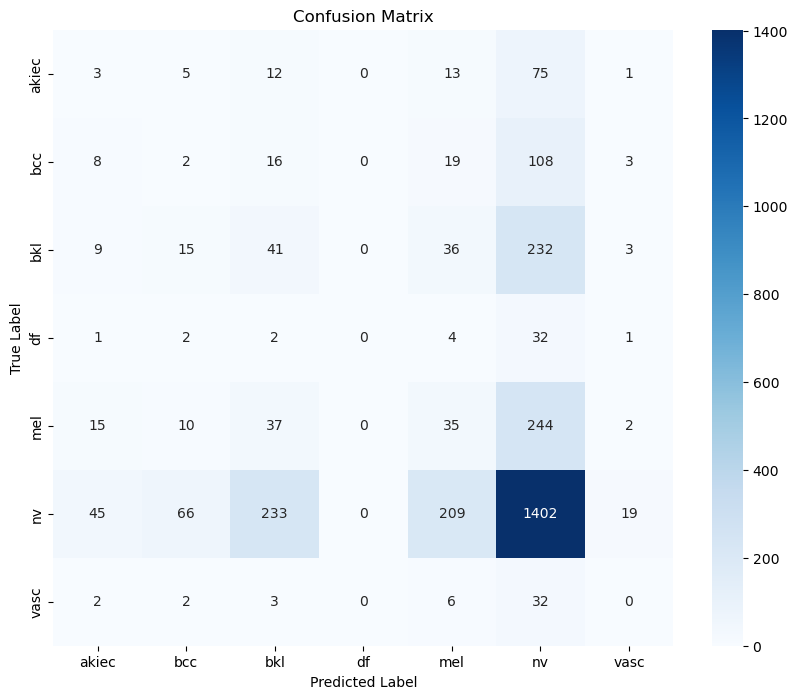

In [10]:
# Evaluation
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("cnn_cm_7_3.png", bbox_inches="tight")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

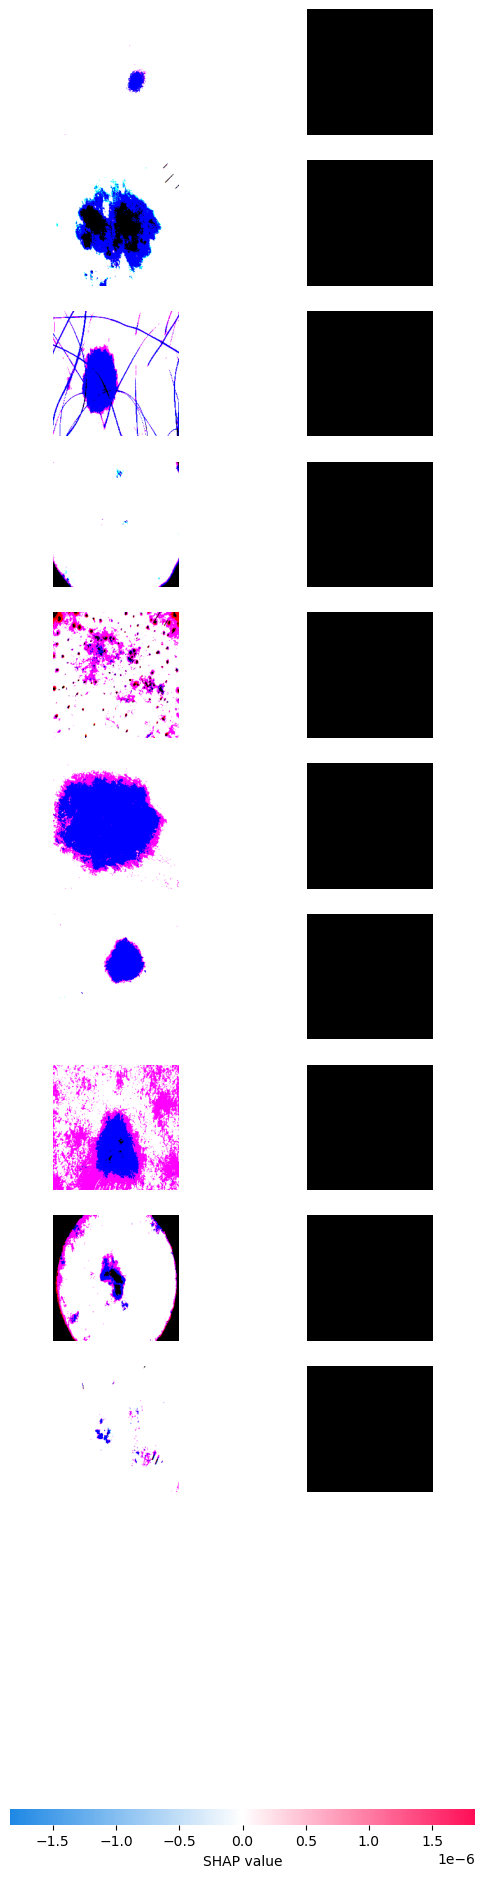

MemoryError: Unable to allocate 3.30 GiB for an array with shape (20, 224, 3, 7, 224, 3, 7) and data type float64

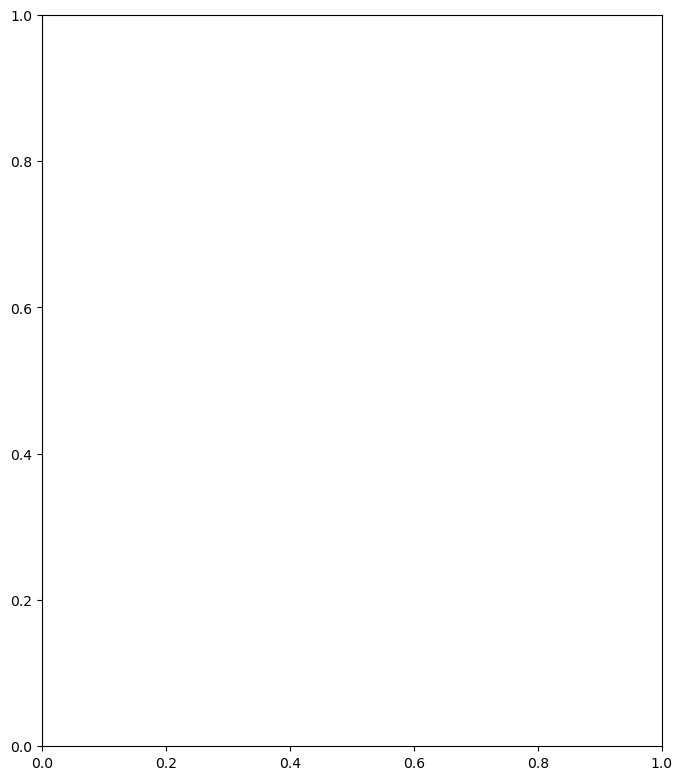

In [16]:

import shap
import lime
import lime.lime_image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('proposedcnn.h5')

# Function to get a batch of data from the generator
def get_batch(generator):
    for x_batch, y_batch in generator:
        return x_batch, y_batch

# Use a smaller subset of data for SHAP and LIME explanations
x_train_batch, _ = get_batch(train_set)
x_test_batch, _ = get_batch(test_set)
x_explain = x_test_batch[:10]  # Use the first 10 samples from the batch for SHAP

# Generate SHAP explanations
explainer = shap.DeepExplainer(model, x_train_batch[:100])  # Use a subset of the training data for efficiency
shap_values = explainer.shap_values(x_explain)  # Explain the first 10 test samples

# Plot SHAP values for a single prediction
shap.image_plot(shap_values, x_explain)
plt.savefig("cnn_shap.png", bbox_inches="tight")

# Generate SHAP summary plot to show feature importance
shap.summary_plot(shap_values, x_explain, plot_type="bar")
plt.savefig("cnn_shap_summary.png", bbox_inches="tight")

# Generate LIME explanations
explainer = lime.lime_image.LimeImageExplainer()

def predict_fn(images):
    return model.predict(images)

for i in range(5):  # Explain the first 5 test samples
    explanation = explainer.explain_instance(x_explain[i], predict_fn, top_labels=3, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(temp)
    plt.title(f'LIME Explanation for Image {i}')
    plt.savefig(f"cnn_lime_{i}.png", bbox_inches="tight")
    plt.show()

# Plot model history (Ensure plot_model_history(history) is defined elsewhere in your script)
plot_model_history(history)

# Explanation of the results
print("SHAP and LIME explanations have been generated for the first few test samples.")
print("SHAP plots illustrate the impact of each pixel on the model's output.")
print("LIME plots highlight the regions in the image that contribute most to the model's predictions.")


In [17]:
!pip install shap lime

import shap
import lime
import lime.lime_image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Load the model
model = load_model('proposedcnn.h5')

# Function to get a batch of data from the generator
def get_batch(generator):
    for x_batch, y_batch in generator:
        return x_batch, y_batch

# Downsample images to reduce memory usage
def downsample_images(images, new_size=(64, 64)):
    return np.array([resize(image, new_size, anti_aliasing=True) for image in images])

# Use a smaller subset of data for SHAP and LIME explanations
x_train_batch, _ = get_batch(train_set)
x_test_batch, _ = get_batch(test_set)
x_explain = downsample_images(x_test_batch[:10])  # Use the first 10 samples from the batch for SHAP

# Downsample the training data for SHAP
x_train_sample = downsample_images(x_train_batch[:100])

# Generate SHAP explanations
explainer = shap.DeepExplainer(model, x_train_sample)  # Use a subset of the training data for efficiency
shap_values = explainer.shap_values(x_explain)  # Explain the first 10 test samples

# Plot SHAP values for a single prediction
shap.image_plot(shap_values, x_explain)
plt.savefig("cnn_shap.png", bbox_inches="tight")

# Generate SHAP summary plot to show feature importance
shap.summary_plot(shap_values, x_explain, plot_type="bar")
plt.savefig("cnn_shap_summary.png", bbox_inches="tight")

# Generate LIME explanations
explainer = lime.lime_image.LimeImageExplainer()

def predict_fn(images):
    upscaled_images = np.array([resize(image, (224, 224, 3), anti_aliasing=True) for image in images])
    return model.predict(upscaled_images)

for i in range(5):  # Explain the first 5 test samples
    explanation = explainer.explain_instance(x_explain[i], predict_fn, top_labels=3, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(temp)
    plt.title(f'LIME Explanation for Image {i}')
    plt.savefig(f"cnn_lime_{i}.png", bbox_inches="tight")
    plt.show()

# Plot model history (Ensure plot_model_history(history) is defined elsewhere in your script)
plot_model_history(history)

# Explanation of the results
print("SHAP and LIME explanations have been generated for the first few test samples.")
print("SHAP plots illustrate the impact of each pixel on the model's output.")
print("LIME plots highlight the regions in the image that contribute most to the model's predictions.")


ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)

In [20]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Load the model
model = load_model('proposedcnn.h5')

def downsample_images(images, target_size=(224, 224)):
    downsampled_images = np.array([resize(image, target_size, anti_aliasing=True) for image in images])
    return downsampled_images

# Sample down images
x_train_sample = downsample_images(x_train_batch[:100])
x_explain = downsample_images(x_test[:10])

# Generate SHAP explanations
explainer = shap.DeepExplainer(model, x_train_sample)
shap_values = explainer.shap_values(x_explain)

# Plot SHAP values for a single prediction
shap.image_plot(shap_values, x_explain)
plt.savefig("cnn_shap.png", bbox_inches="tight")

# Generate SHAP summary plot to show feature importance
shap.summary_plot(shap_values, x_explain, plot_type="bar")
plt.savefig("cnn_shap_summary.png", bbox_inches="tight")


NameError: name 'x_test' is not defined